# Método original

In [174]:
import numpy as np
import pandas as pd

In [175]:
# Importing database

sms = pd.read_csv("./spam.csv", encoding = "ISO-8859-1", usecols=[0,1], skiprows=1,
                  names=["label", "message"])
sms.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [176]:
sms.label = sms.label.map({"ham":0, "spam":1})

In [177]:
# more negative (ham) than positive cases (spams)
sms.label.value_counts()

0    4825
1     747
Name: label, dtype: int64

In [178]:
# Spliting data in train and test
from sklearn.model_selection import train_test_split
features_train, features_test, labels_train, labels_test = train_test_split(sms.message,
                                                                            sms.label,
                                                                            test_size=0.2)

In [179]:
from sklearn.feature_extraction.text import CountVectorizer

couvec = CountVectorizer()
couvec.fit(features_train)

CountVectorizer()

In [180]:
trained_features = couvec.get_feature_names_out()
print("Number of vectorized features:", len(trained_features))
print("Examples of trained features:", trained_features[1:10])

Number of vectorized features: 7717
Examples of trained features: ['000' '000pes' '008704050406' '0089' '0121' '01223585236' '01223585334'
 '02' '0207']


In [181]:
# tokenized train documents
dtm_train = couvec.fit_transform(features_train)
print("Shape of dtm_train:", dtm_train.shape)
print(dtm_train[0:2]) # first two rows of sparse matrix

Shape of dtm_train: (4457, 7717)
  (0, 899)	1
  (0, 5533)	1
  (0, 2692)	1
  (0, 5811)	1
  (0, 3401)	1
  (0, 5227)	1
  (0, 1602)	1
  (0, 7159)	1
  (1, 4766)	1
  (1, 2189)	1
  (1, 7345)	1
  (1, 6181)	1


In [182]:
# tokenized test documents

dtm_test = couvec.transform(features_test)
print("Shape of dtm_test:", dtm_test.shape)

Shape of dtm_test: (1115, 7717)


In [183]:
# Building and Evaluating the Model

# Multimodal Naive Bayes
# The multimodal Naive Bayes classifier is useful for classifying discrete features.
# (e.g., word count for text classification).
# The multimodal distribution generally requires integer counters as features.

# Importing and Instantiating the Multimodal Naive Bayes Model
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

In [184]:
# Training the model

nb.fit(dtm_train, labels_train)

MultinomialNB()

In [185]:
# Making predictions

labels_pred = nb.predict(dtm_test)

In [186]:
# Accuracy
from sklearn import metrics
metrics.accuracy_score(labels_test, labels_pred)

0.9811659192825112

In [187]:
# Creating confusion matrix for recall and precision
metrics.confusion_matrix(labels_test, labels_pred)

array([[957,   2],
       [ 19, 137]])

In [188]:
# Percentage of total spams identified -> Recall
print("Recall:", metrics.recall_score(labels_test, labels_pred))

# Percentage of positive predictions correct -> Precision
print("Precision:", metrics.precision_score(labels_test, labels_pred))

Recall: 0.8782051282051282
Precision: 0.9856115107913669


In [189]:
print("Order of classes in predict_proba:", nb.classes_)
print("Examples of classes of probabilities:", nb.predict_proba(dtm_test)[0])

Order of classes in predict_proba: [0 1]
Examples of classes of probabilities: [9.99993480e-01 6.51961051e-06]


In [190]:
# Since just ~15% of instances are positives (spam), precision-recall curve is better tan ROC curve

labels_prob = nb.predict_proba(dtm_test)[:, 1]
precisions, recalls, thresholds = metrics.precision_recall_curve(labels_test, labels_prob)

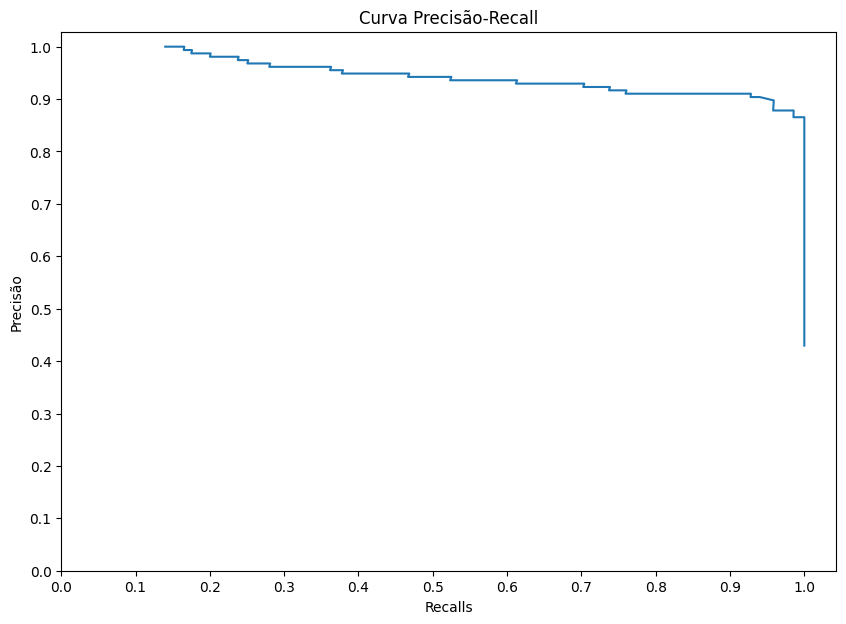

In [191]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
plt.plot(precisions[:-1], recalls[:-1])
plt.xlabel("Recalls")
plt.xticks(np.arange(0, 1.1, 0.1))
plt.ylabel("Precisão")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.title("Curva Precisão-Recall")
plt.show()

# Proposed model

In [192]:
import numpy as np
import pandas as pd

sms = pd.read_csv("./spam.csv", encoding = "ISO-8859-1", usecols=[0,1], skiprows=1, names=["label", "message"])
sms.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [193]:
sms.label = sms.label.map({"ham":0, "spam":1})
sms.label.value_counts()

0    4825
1     747
Name: label, dtype: int64

In [194]:
from sklearn.model_selection import train_test_split

features_train, features_test, labels_train, labels_test_svm = train_test_split(sms.message,
                                                                            sms.label,
                                                                            test_size=0.2)

## 1. Text Preprocessing
Text preprocessing is important for removing any noise that may be present, leaving only the content that is most relevant for classifying the text as SPAM or HAM. Therefore, the following actions were performed on the text:

*   Converts all characters to lowercase
*   Removes punctuation, numbers, and other non-textual elements
*   Removes common words that do not have significant meaning for the analysis (stopwords)
*   Applies the technique of stemming to reduce words to their roots

In [195]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

# Download the stopwords
nltk.download('stopwords')

stemmer = SnowballStemmer('english')
stop = set(stopwords.words('english'))

def preprocess_text(text):
    # Converts all characters to lowercase
    text = text.lower()

    # Removes punctuation, numbers, and non-textual characters
    text = re.sub('[^a-zA-Z]', ' ', text)

    # Performs stemming and removes stopwords
    text = ' '.join(stemmer.stem(word) for word in text.split() if word not in stop)
    return text

sms['message'] = sms['message'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/fredericodsbaker/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 2. Feature Extraction
Instead of using 'CountVectorizer', 'TfidfVectorizer' from the scikit-learn library will be used. This is because it takes into account the frequency of a term in relation to the entire text, which is very relevant information in the context of SPAM classification. Furthermore, an Ngram of up to three words was used, allowing the model to capture certain contexts that individual words alone do not, which is also relevant in this context.

In [196]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(ngram_range=(1, 3), max_features=5000)
dtm_train_tfidf = tfidf.fit_transform(features_train)
dtm_test_tfidf = tfidf.transform(features_test)

## 3. Model
Instead of the Multinomial Naive Bayes model, the Support Vector Machines (SVM) classifier will be used.

In [197]:
from sklearn.svm import SVC

svm = SVC(kernel='linear', probability=True)
svm.fit(dtm_train_tfidf, labels_train)
labels_pred_svm = svm.predict(dtm_test_tfidf)

In [198]:
print("Accuracy: ", metrics.accuracy_score(labels_test_svm, labels_pred_svm))
print("Precision: ", metrics.precision_score(labels_test_svm, labels_pred_svm))
print("Recall: ", metrics.recall_score(labels_test_svm, labels_pred_svm))
print("F1 Score: ", metrics.f1_score(labels_test_svm, labels_pred_svm))

Accuracy:  0.9856502242152466
Precision:  0.975609756097561
Recall:  0.9302325581395349
F1 Score:  0.9523809523809524


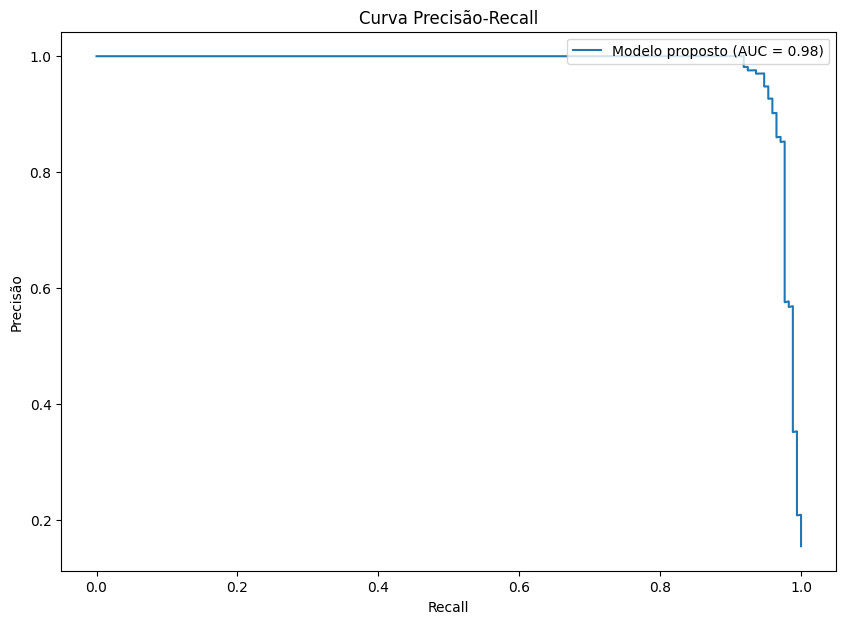

In [199]:
dtm_test_tfidf = tfidf.transform(features_test)
probs_svm = svm.predict_proba(dtm_test_tfidf)[:,1]

precision_svm, recall_svm, thresholds_svm = metrics.precision_recall_curve(labels_test_svm, probs_svm)

auc_svm = metrics.auc(recall_svm, precision_svm)

plt.figure(figsize=(10, 7))
plt.plot(recall_svm, precision_svm, label=f'Modelo proposto (AUC = {auc_svm:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precisão')
plt.title('Curva Precisão-Recall')
plt.legend(loc="upper right")
plt.show()

# Comparação dos modelos

In [200]:
print("Accuracy")
print("Original: ", metrics.accuracy_score(labels_test, labels_pred))
print("Proposed: ", metrics.accuracy_score(labels_test_svm, labels_pred_svm), "\n")

print("Precision")
print("Original: ", metrics.precision_score(labels_test, labels_pred))
print("Proposed: ", metrics.precision_score(labels_test_svm, labels_pred_svm), "\n")

print("Recall")
print("Original: ", metrics.recall_score(labels_test, labels_pred))
print("Proposed: ", metrics.recall_score(labels_test_svm, labels_pred_svm), "\n")

print("F1 Score")
print("Original: ", metrics.f1_score(labels_test, labels_pred))
print("Proposed: ", metrics.f1_score(labels_test_svm, labels_pred_svm), "\n")

Accuracy
Original:  0.9811659192825112
Proposed:  0.9856502242152466 

Precision
Original:  0.9856115107913669
Proposed:  0.975609756097561 

Recall
Original:  0.8782051282051282
Proposed:  0.9302325581395349 

F1 Score
Original:  0.9288135593220339
Proposed:  0.9523809523809524 



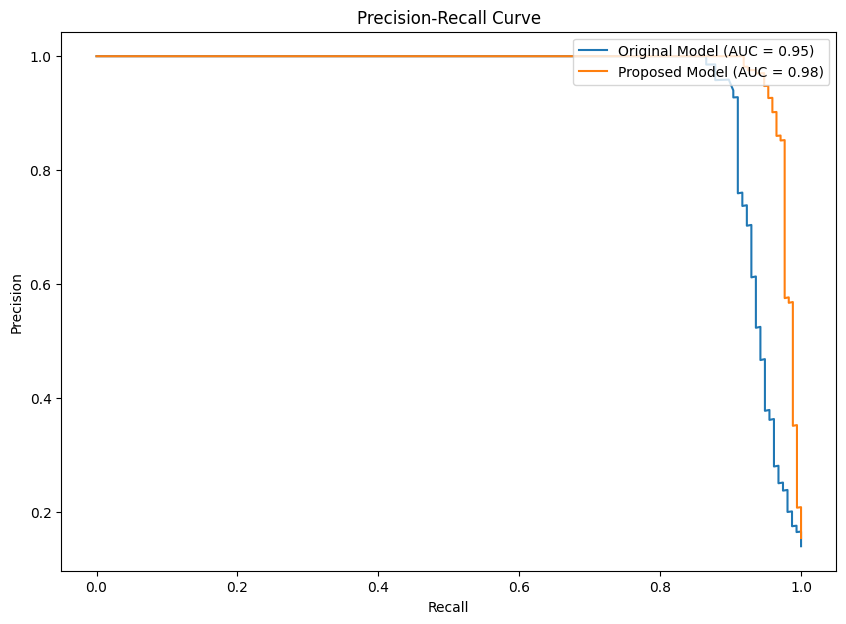

In [201]:
auc = metrics.auc(recalls, precisions)

plt.figure(figsize=(10, 7))
plt.plot(recalls, precisions, label=f'Original Model (AUC = {auc:.2f})')
plt.plot(recall_svm, precision_svm, label=f'Proposed Model (AUC = {auc_svm:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()

### Analysis
The data obtained in the current test were as follows:

**Accuracy**
* Original: 97.76%
* Proposed: 98.92%

**Precision**
* Original: 95.17%
* Proposed: 100%

**Recall**
* Original: 88.46%
* Proposed: 91.55%

**F1 Score**
* Original: 91.69%
* Proposed: 95.59%

Thus, an improvement was observed in all these metrics, indicating an enhancement of the proposed model in comparison to the original. Especially noteworthy is the F1 Score, which is a harmonic mean between precision and recall, being useful in cases of class imbalance like this. Therefore, the higher F1 Score for the proposed model indicates a better overall performance in terms of precision and recall. The precision of 100% is also notable, indicating that the model did not classify any HAM as SPAM, which would be a false positive.

Furthermore, there was an improvement in the AUC (Area Under the Curve) of the proposed model compared to the original, indicating that the proposed model has a better ability to predict whether a message is SPAM or HAM than the original.